In [29]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [30]:
d = pd.read_csv('data/cleaned_data_together.csv')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)
df = df.set_index(pd.DatetimeIndex(df.DateTime))

In [31]:
df['Change'] = df['Henry Hub Price $/MMBtu'] - df['Henry Hub Price $/MMBtu'].shift(1)

In [32]:
small_df= df[1600:2900]

In [33]:
small_df.head()

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,Change
DateTime,,,,,,,,,
2014-05-20,2014-05-20,4.53,62.0110,2356978.0,1160.0,322670.0,2741240.0,140,-0.01
2014-05-21,2014-05-21,4.57,63.2338,2356978.0,1160.0,322670.0,2741240.0,141,0.04
2014-05-22,2014-05-22,4.57,63.9370,2356978.0,1267.0,322670.0,2741240.0,142,0.00
2014-05-23,2014-05-23,4.40,63.9691,2356978.0,1267.0,322670.0,2741240.0,143,-0.17
2014-05-24,2014-05-24,4.40,63.8906,2356978.0,1267.0,322670.0,2741240.0,144,0.00


In [43]:
test = sm.tsa.stattools.adfuller(small_df['Change'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


In [41]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

(-0.1, 0.1)

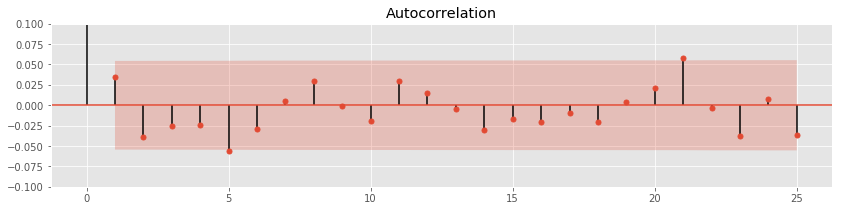

In [49]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(small_df['Change'], lags=25, ax=ax)
ax.set_ylim([-.1, .1])

(-0.1, 0.1)

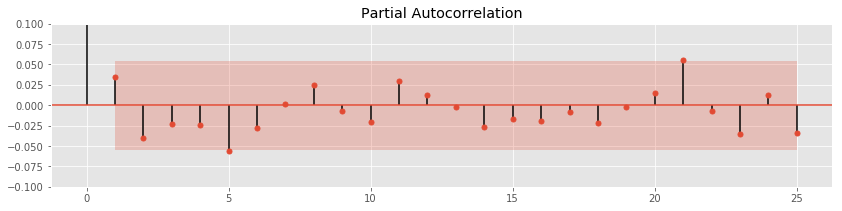

In [50]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(small_df['Change'], lags=25, ax=ax, method='ywmle')
ax.set_ylim([-.1, .1])

In [51]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [59]:
X = small_df['Change'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(test), yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.00987


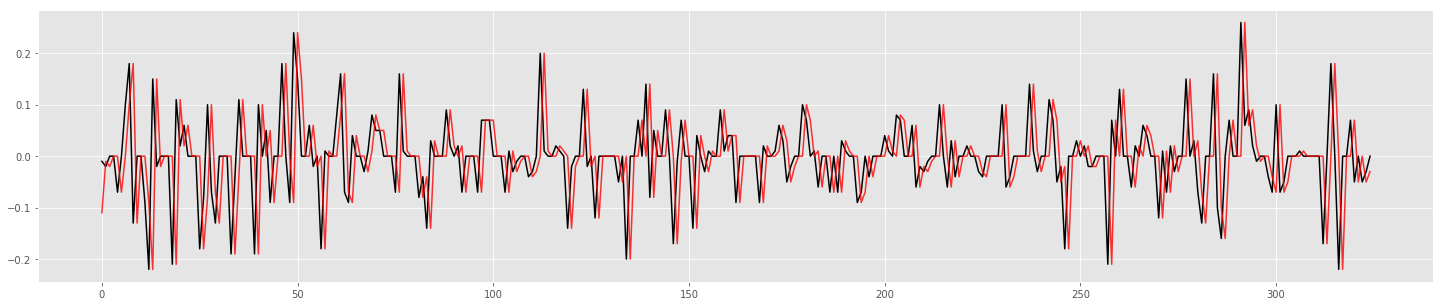

In [60]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
#axs.set_xlim([0, 100])
#axs.set_ylim([2.5, 3.5])
plt.show()

In [61]:
X = small_df['Change']
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(0, 1, 0)).fit()

(-1, 1)

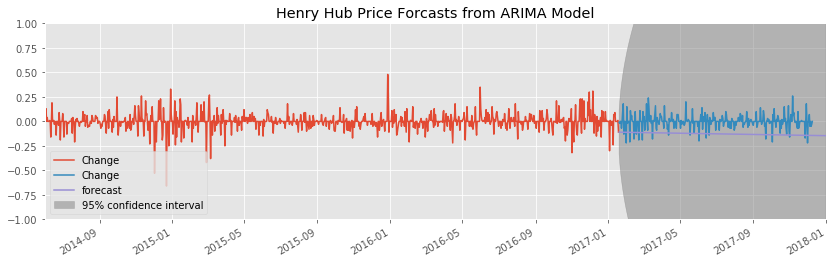

In [63]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(train['2014-06':].index, train['2014-06':])
ax.plot(test)
fig = model.plot_predict('2017-01-19', '2018', 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Henry Hub Price Forcasts from ARIMA Model")
#ax.set_xlim([0, 40])
ax.set_ylim([-1, 1])